# Geography AI Workshop 02 Convolutional neural networks

## Introduction

In this exercise, we'll build a convolutional neural network (CNN) for image classification. This is one of the original and more straightforward uses of CNNs. More complex uses include:

- Semantic image segmentation
- Image denoising or reconstruction
- Working with video streams

But all methods are based around two basic operations: 

- Convolution: in this step, the network learns a series of kernels or filters that transform the original image in some way. These are similar to filters that are used in standard image processing (e.g. low-pass filters), but filters are chosen by how well the transformed image maps to the outcome variable. To put this another way, these filters identify shapes or features that are important in differentiating between different outcomes
- Max-pooling: in this step, the image resolution is transformed. In general, the resolution is halved, by aggregating groups of four pixels in a two by two window. Pooling acts to aggregate smaller scale features into larger objects

In general, these steps are repeated several times. As this progresses, the small shapes identified in the first set of convolutions are progressively combined into larger structures. For example, a series of small curves or lines could be aggregated into a cat's eye.

The code in this example is modified from a blog by BEEILAB: 
https://medium.com/@beeilab.yt/land-use-land-cover-classification-using-satellite-images-and-deep-learning-a-step-by-step-guide-27fea9dbf748


### Image classification

The basic idea behind image classification is to link *features* of an image to a single label or class. For example, we might have a photograph of a cat, with the label `Cat` and one of a dog with the label `Dog`. The goal of the model is to identify what shapes and colors, and combination of these can help differentiate between these two classes. 


### Data

For this exercise, we'll use the EuroSat benchmarking dataset from: https://zenodo.org/records/7711810:

> EuroSAT is a land use and land cover classification dataset. The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 LULC classes with a total of 27,000 labeled and geo-referenced images. 

The images are available as both multispectral and RGB. We'll just use the RGB images here to limit the amount of data we need to deal with, but this code can be easily extended to use the multispectral data. In the paper that accompanies this dataset, the authors were able to get a 98.5% accuracy in prediction. We won't get that high here, as we'll take a few short cuts to make the code run faster, but this should give you an idea of what is possible with these networks. 

The images are available on the workshop Google drive in the zip file *EuroSat_RGB.zip*. Download this now, and move it to a folder that is easy to find on your computer, and unzip it. 

Once you have unzipped the data, take a look in the *EuroSat_RGB* folder. This is already set up in the standard way for image classification, where all images for a given class are kept in a single folder for that class. The name of the folders can then used as the *label* for each image, and is what we will use. 

- EuroSat_RGB
  - AnnualCrop
  - Forest
  - HerbaceousVegetation
  - ...

Note that this is a specific layout for image classification. There are other options, for example, if you are working with continuous outcomes.

### Setup environment

I'd suggest making a new virtual environment or Conda environment for this exercise:

```
conda create -name tf
conda activate tf
```

You will need to make sure you have the following Python packages installed. Please ask if you have any issues installing these:

- `numpy`
- `gdal`
- `matplotlib`
- `seaborn`
- `tensorflow`
- `PIL` 
- `scikit-learn`


## Data processing
Let's start, as usual, by loading the libraries we'll need to get started:

In [1]:
from osgeo import gdal
import numpy as np
import os
from PIL import Image 
from IPython.display import display 
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

Now set the path to the folder containing the images you downloaded. If you have any questions about setting this path, please ask. 

In [2]:
# path to image folders
image_path = "./datafiles/EuroSAT_RGB/"

You can visualize any of the images using the Python image library (you'll need to install this) by joining the folder path to one of the image names (we'll also check the size of the image):

In [3]:
im_file = os.path.join(image_path, "Forest", "Forest_10.jpg")
im = gdal.Open(im_file).ReadAsArray()

print(im.shape)

(3, 64, 64)


/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


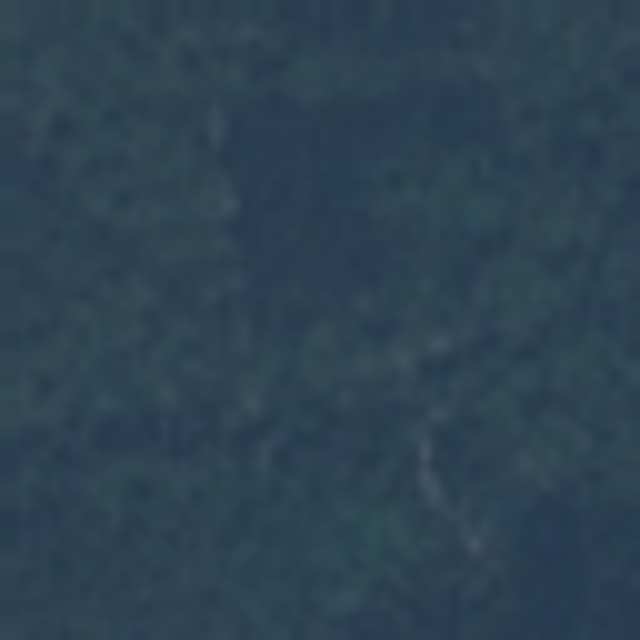

In [4]:
im = Image.open(im_file)
#show image
im = im.resize((640,640))
display(im)

You can try other images by changing the folder name and filename. Note that these are somewhat idealized images, chosen for a benchmarking exercise. 

Next, we'll define the classes that we are going to process. There are 10 different types of landcover in the dataset, making this a multi-class classification problem. We could provide list as a Python list, or more usefully, simply extract the labels from the folder names:


In [5]:
# List the class folders within the main folder
classes = sorted(os.listdir(image_path))

# Create an empty dictionary to store class names and their corresponding numerical labels
dict_class = {}

# Iterate through the classes and assign a numerical label to each class
for i in range(len(classes)):
    # The numerical label is assigned as i+1 to start from 1
    dict_class.update({classes[i]: i + 1})

# Define the total number of classes in your dataset
num_classes = len(classes)

# Display the resulting dictionary
print(dict_class)

{'AnnualCrop': 1, 'Forest': 2, 'HerbaceousVegetation': 3, 'Highway': 4, 'Industrial': 5, 'Pasture': 6, 'PermanentCrop': 7, 'Residential': 8, 'River': 9, 'SeaLake': 10}


The original images are 64x64 pixels. As these are small, we can use them at their full resolution. For larger images, we'd either need to reduce their resolution or divide them into smaller images. 

We'll set a few constants here: the image size (`patch_size`) and the number of images we want to use from each class (`patch_number`). The full set has 3000 images per class, but here will limit this to the first 1000 to speed up model training. A good follow-up exercise would be to increase this to see what impact it has on the model's predictive skill. We also define the number of channels - these will define the input tensors. These will be rank 3 tensors, with dimensions 64x64x3. The channels can easily be changed here to include additional bands as necessary (Sentinel-2 multispectral data has 13 bands, for example).

In [6]:
# Specify the number of images to use
patch_numbers = 1000

# Define the size of each image patch
patch_size_x = 64
patch_size_y = 64

# Specify the number of spectral bands in your satellite imagery
channels = 3

Now we'll create some empty arrays to store the information of both the images (`X`) and labels or classes (`y`). As this is a (relatively) small dataset, we can load the images into memory. For larger sets of images, the tensorflow Keras API provides a series of data loaders that can pass images in batches from disk and avoid memory issues.

In [7]:
X = np.zeros((patch_numbers * num_classes, patch_size_x, patch_size_y, channels), dtype='float32') ## Images
Y = np.zeros((patch_numbers * num_classes, num_classes), dtype='float32') ## Labels

Now we'll read in and store the images in a big loop. We'll first iterate over the different class folders, then over the images contained within them. We use `gdal` to read in the image, then copy each band into a temporary numpy array. Once the bands are read, we transfer them into the `X` array created earlier. At the same time, we store the folder name in `y` as the label. As these are 8-bit RGB images, the intensity values range from 0-255. We standardize to a [0-1] range by dividing the pixel values by 255. This form of standardization (min-max standardization) is frequently used with neural networks to avoid issues in weight calculation.

In [8]:
# Initialize a counter to keep track of the total number of patches processed
Counter = 0
# Iterate through each class in your dataset
for cls in classes:
    print(f"Reading {cls}")
    # Get a list of images in the current class folder
    image_list = os.listdir(image_path + cls)
    image_list = image_list[0:patch_numbers]
    # Iterate through each image in the current class
    for img in image_list:
        # Read the image using GDAL (assuming it's a raster image)
        image = gdal.Open(image_path + cls + '/' + img).ReadAsArray()

        # Create an empty array to store the reshaped image with the desired patch size and bands
        new_image = np.zeros((patch_size_x, patch_size_y, channels), dtype='float32')

        # Iterate through each band in the original image
        for b in range(channels):
            # Copy the band to the corresponding slice in the new image
            new_image[:, :, b] = image[b, :, :] / 255.

        # Store the reshaped image in the X array
        X[Counter, :, :, :] = new_image

        # Determine the column (class label) for the current image and update the Y array
        column = dict_class[cls]
        Y[Counter, column - 1] = 1

        # Increment the counter
        Counter = Counter + 1

Reading AnnualCrop
Reading Forest
Reading HerbaceousVegetation
Reading Highway
Reading Industrial
Reading Pasture
Reading PermanentCrop
Reading Residential
Reading River
Reading SeaLake


In [9]:
# Print the shapes of the X and Y arrays for verification
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (10000, 64, 64, 3)
Y shape:  (10000, 10)


### Training and test sets

Before building the CNN model, we'll subdivide our data into three subsets: training, testing and validation. W'll use Scikit-Learn's `train_test_split` function to do this, and we'll do it in two steps. First we use am 80/20 split to remove 20% of the original data for testing. This will be held in reserve during model training and only used to assess the final model:

In [10]:
from sklearn.model_selection import train_test_split

Second, we split the other 80% into a training and validation set using another 80/20 split. The training set will be used to set model weights, and the validation set used to assess performance during training. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print('X shape: ', X_train.shape)
print('Y shape: ', y_train.shape)

X shape:  (8000, 64, 64, 3)
Y shape:  (8000, 10)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)
print('X shape: ', X_train.shape)
print('Y shape: ', y_train.shape)

X shape:  (6400, 64, 64, 3)
Y shape:  (6400, 10)


## CNN model

Let's now set up the model. We'll now set up the model. There are a few things we need to define here:
- The loss function
- Performance metrics
- Model optimizers
- The architecture

### Loss function

The loss function is used during training to measure how well the current set of model weights map between inputs and output, and is then used in adjusting these. A good option for the loss function is `categorical_crossentropy`, which tries to maximize the accuracy across multiple groups

In [13]:
my_loss = tf.keras.losses.CategoricalCrossentropy ()

### Performace metric

The metric is the error between the predicted class and observed class aggregated across all samples. There are a large number of these, but here we'll us accuracy. This is probably the simplest of all metrics and gives the proportion of all images that are correctly classified.

In [14]:
my_metrics = ['accuracy']

### Optimizer

The optimizer is used to adjust weights during the backpropagation or training of the network. We'll use the `Adam` optimizier - this is well suited to large and complex problems, and is computationally very efficient. We'll set the learning rate to 0.0001. This is an important hyperparameter in these models as it this limits the changes to model weights during training, and can help limit overfitting. If you have time, it's worth re-training the model with a higher or lower rate to see the effect. 

In [15]:
my_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

### Model architecture

We'll create a relatively simple CNN here. This will have a set of convolution / max-pooling steps, and then the inputs will be passed through a series of densely connected layers before the output. Some things to note:

- We use a Python function to create the model. This allows you to re-initialize the model very easily. 
- The first layer (`inputs`) will take the input images/tensors. For this layer, we need to specify the size of these (`input_shape` is defined below)
- In the next few lines, we define 3 convolution/pooling steps.
    - Convolution steps use `Conv2D` for two-dimensional convolutions on an image. The set of arguments here are a) the number of convolutions; b) the size of the kernel window that is used for the convolution of each pixel; c) an activation function (ReLu). 
    - Max-pooling is carried out with `MaxPooling2D`. The argument here is the size of the pooling window. This is the factor by which the resolution of the images is reduced
- The `Flatten` layer converts from 2D arrays in the previous step to a 1D vector. So an image that is 16x16 will become a 1x256 vector. This allows connection to the following dense layers
- `Dense` layers are simple layers of mulitple neurons, each of which is connected to the previous and successive layer
- The final layer `dense3` is the one that provides a prediction for each class. As such, it needs to have as many nodes as we have classes (10), and the activation function is a softmax. This converts the final weights for each class into a set of probabilities that sum to 1 across all classes
- We finish the model by calling the `Model` function to tie all of this together. Note that this requires us to specify which of the layers will receive the input tensors, and which will output values to be compared to the target masks. 


In [16]:
from tensorflow.keras import layers
def cnn_model(input_shape, num_classes=10):
    # Define the input layer with the specified shape
    inputs = layers.Input(shape=input_shape)

    # Convolutional and pooling layers to capture hierarchical features
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten the output for feeding into dense layers
    flat = layers.Flatten()(pool3)

    # Dense layers for classification with ReLU activation
    dense1 = layers.Dense(128, activation='relu')(flat)
    dense2 = layers.Dense(256, activation='relu')(dense1)

    # Output layer with softmax activation for multi-class classification
    dense3 = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create the model with the defined inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=dense3)

    return model

With this function ready, we can now build the model architecture. We use the X_training data to get the input shape, then build and display the model

In [17]:
input_shape = X_train.shape[1:]

model = cnn_model(input_shape, num_classes=num_classes)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856 

The total number of model parameters or weights is shown at the end of this output. Our model has a little under 720,000 weights to train (hence the need for a lot of images). As a comparison, a simple bivariate regression model has a grand total of 3.

We can also generate a simple visualization:

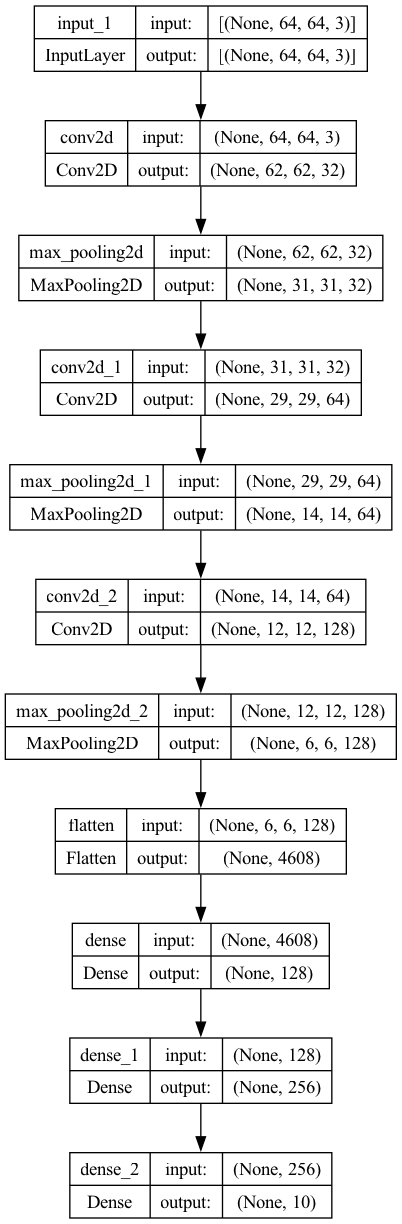

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

Next step is to `compile` the model. This just connects the model architecture to the optimizer, loss function and metric(s).

In [19]:
model.compile(
    optimizer=my_opt,
    loss=my_loss,
    metrics=my_metrics
)

## Model training

We'll now train the model for 30 epochs, using the `fit()` method. We need to provide the following arguments:

- `x`: The input training data
- `y`: The training labels or classes
- `validation_data`: the generator of the validation samples
- `epochs`: number of full training iterations
- `batch_size`: number of images that are passed to the network before updating weights
- We also tell the model to `shuffle` the input images during training. This can be important as deep learning networks learn best when there is a lot of variation in the inputs, including the order that they are received

This takes a couple of minutes to train (on my laptop). It's worth remembering what is going on here: the algorithm is reading in batches of 32 images, rescaling them, updating model weights through back propagation and then repeating the whole thing 30 times. As we previously defined a separate validation set (and image generator), this routine will calculate two losses:
- The training loss. This is how accurately the model can predict the images that are being used to update the weights
- The validation loss. This is how accurately the model can predict a set of training images that are not used in updating the weights

As the model continues to train, you should see the loss (the crossentropy) decrease for both of these, but will likely stabilize at a certain point. The accuracy should (hopefully) increase over time. 

In [20]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=30,
    shuffle=True
)

Epoch 1/30
200/200 [==============================] - 6s 26ms/step - loss: 1.9179 - accuracy: 0.2511 - val_loss: 1.5381 - val_accuracy: 0.3881
Epoch 2/30
200/200 [==============================] - 5s 27ms/step - loss: 1.3902 - accuracy: 0.4569 - val_loss: 1.2987 - val_accuracy: 0.4919
Epoch 3/30
200/200 [==============================] - 5s 27ms/step - loss: 1.2417 - accuracy: 0.5344 - val_loss: 1.2073 - val_accuracy: 0.5419
Epoch 4/30
200/200 [==============================] - 5s 26ms/step - loss: 1.1591 - accuracy: 0.5645 - val_loss: 1.2454 - val_accuracy: 0.4888
Epoch 5/30
200/200 [==============================] - 5s 26ms/step - loss: 1.1209 - accuracy: 0.5786 - val_loss: 1.1731 - val_accuracy: 0.5419
Epoch 6/30
200/200 [==============================] - 5s 26ms/step - loss: 1.0564 - accuracy: 0.6091 - val_loss: 1.0209 - val_accuracy: 0.6281
Epoch 7/30
200/200 [==============================] - 5s 27ms/step - loss: 0.9828 - accuracy: 0.6411 - val_loss: 1.0306 - val_accuracy: 0.6025

## Model evaluation

We'll now evaluate the trained model. First, we'll plot out the changes in the accuracy and loss function across the training epochs. This visualization is an important step as it helps show if the model has been well trained. Ideally, the loss function will show a fairly gradual decline to a minimum, and the accuracy will show a gradual increase to a plateau. If these do not stabilize, this indicates under-training and may require a higher learning rate or more epochs. If the decline in the loss is very sharp, the model may be overfit to the data. 

All the information about the model training is held in the output `history` object. 

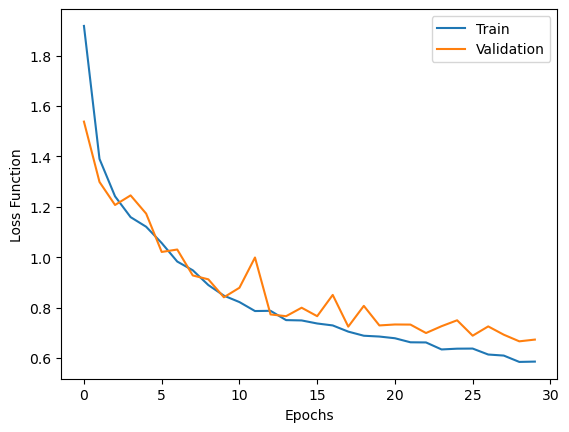

In [21]:
## Plot the loss
plt.plot(np.array(history.history['loss']), label='Training Loss')
plt.plot(np.array(history.history['val_loss']), label='Validation Loss')
plt.ylabel('Loss Function')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

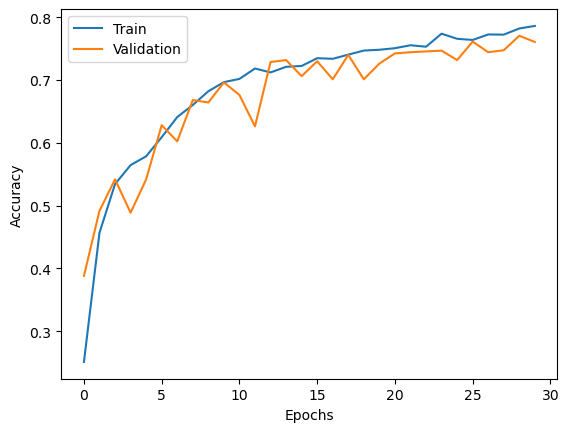

In [22]:
# Plot the accuracy
plt.plot(np.array(history.history['accuracy']), label='Training Accuracy')
plt.plot(np.array(history.history['val_accuracy']), label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Next, we'll see how the model performs in predicting classes for the test data set. As a reminder, this dataset was not used in the training (the model hasn't 'ssen' these images), and is considered to be a good independent test of predictive skill. Here, we use the `evaluate` method to calculate a testing loss and accuracy:

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Cross-entropy loss: {test_loss}')
print(f'Accuracy: {test_acc}')

63/63 [==============================] - 1s 8ms/step - loss: 0.6512 - accuracy: 0.7620
Cross-entropy loss: 0.6511670351028442
Accuracy: 0.7620000243186951


While this gives us an overall metric for the models predictive skill, we can also dig into this a little further, including looking at how well individual classes were predicted. To do this, we first predict for each test image:

In [24]:
y_pred = model.predict(X_test)
print(y_pred.shape)

63/63 [==============================] - 1s 7ms/step
(2000, 10)


This gives us 10 predictions for each image - i.e. one per class:

In [25]:
y_pred[0,:]

array([9.6265209e-01, 6.4594369e-17, 8.6687319e-03, 4.5714066e-03,
       1.1981401e-08, 2.1303407e-07, 2.3839913e-02, 1.3672310e-12,
       3.9685885e-05, 2.2788155e-04], dtype=float32)

To get a predicted label for comparison with the observed labels, we can simply find the maximum of these ten predictions:

In [26]:
prediction = np.argmax(y_pred, axis=1)
actual = np.argmax(y_test, axis=1)

With the predicted and observed labels, we can now use Scikit-Learn's broad range of evaluation metrics. For example, to calculate the precision and recall
- Precision is the ratio of the number of images that were correctly predicted for a class to the total number of images that were predicted for that class (correctly or incorrectly). 
- Recall is the ratio of of the number of images that were correctly predicted for a class to the total number of images in that class. This is also called the sensitivity

In [27]:
# Importing necessary libraries
from sklearn.metrics import precision_score, recall_score

precision = precision_score(actual, prediction, average='macro')
recall = recall_score(actual, prediction, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.7636964513058515
Recall: 0.764794056918862


We can now make a confusion matrix between the observed and predicted classes. This shows the number of images that were correctly or incorrectly predicted. In addition, for each incorrectly predicted image, it is possible to see what it was predicted as. This can help in understanding if a certain class is consistently confused with another. 

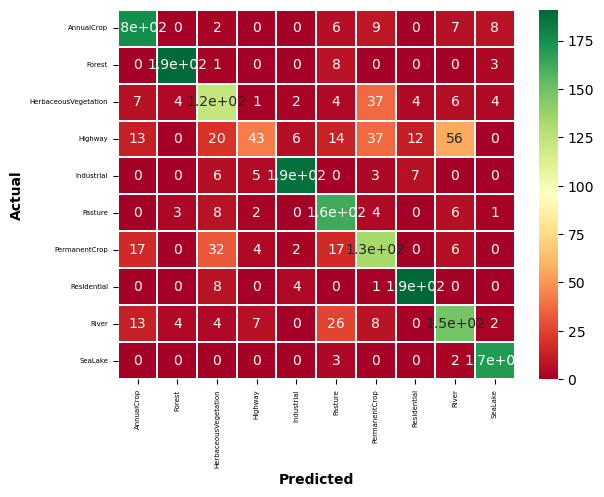

In [28]:
from sklearn.metrics import confusion_matrix

## Create a confusion matrix
cmat = confusion_matrix(actual, prediction)

## Get labels for the plot
actual_class = classes  # Class labels for y-axis
predict_class = classes  # Class labels for x-axis

b = sns.heatmap(cmat, annot=True, cmap='RdYlGn', linewidths=.2, 
                yticklabels=actual_class, xticklabels=predict_class)
b.set_yticklabels(actual_class, size=5)
b.set_xticklabels(predict_class, size=5)
plt.ylabel('Actual', fontsize=10, fontweight='bold')
plt.xlabel('Predicted', fontsize=10, fontweight='bold')

plt.show()

We can also visualize this as the percentage of images, which is sometimes easier to compare across classes

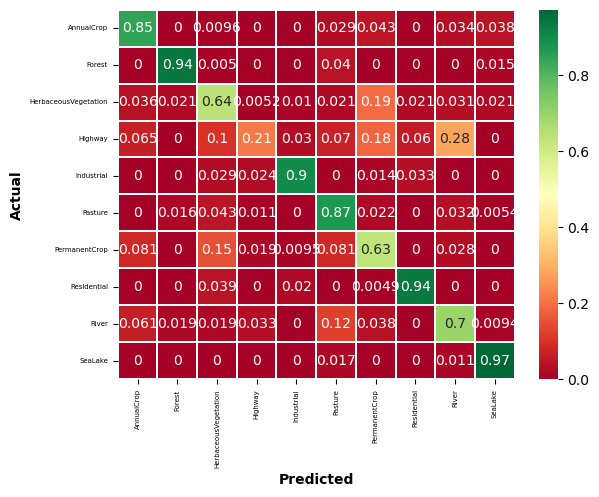

In [29]:
cmat = confusion_matrix(actual, prediction, normalize='true')

b = sns.heatmap(cmat, annot=True, cmap='RdYlGn', linewidths=.2, 
                yticklabels=actual_class, xticklabels=predict_class)
b.set_yticklabels(actual_class, size=5)
b.set_xticklabels(predict_class, size=5)
plt.ylabel('Actual', fontsize=10, fontweight='bold')
plt.xlabel('Predicted', fontsize=10, fontweight='bold')

plt.show()

## Final thoughts

The confusion matrix shows that the class-based accuracy varies substantially (compare highways to sea/lake). Overall the predictive skill is reasonable, particularly given some of the short-cuts that were taken here (subsets of data, realtively few training epochs). There are a variety of ways that this model can be improved on:
- Using all the images
- Using the multispectral images
- Using a more complex CNN with a larger number of layers
- Using a pre-trained model (one trained on a very large number of images that can be modified for this set